In [1]:
import gc
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from time import time
from datetime import date, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [2]:
# Set the figure parameters
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['figure.figsize'] = (15, 8)  # 图片大小
# plt.rcParams['figure.dpi'] = 300  # 显示图片的分辨率
plt.rcParams['savefig.dpi'] = 300  # 保存图片的分辨率

In [3]:
pd.set_option('display.max_columns', 500)

# 1 预处理

In [4]:
sales = pd.read_csv("../data/daily-sales-2.csv", sep=',', parse_dates=['creation_date'])
sales = sales.drop_duplicates()  # 由于取数造成的重复
sales = sales[sales['sales_cen_wid'] != -1]  # 删除销售中心不明的记录
sales = sales[sales['creation_date'] <= '2018-08-31']  # 减少数据量
sales.set_index(['sales_cen_wid', 'customer_wid', 'item_code', 'creation_date'], inplace=True)

# sales = pd.read_csv(
#     "../data/daily-sales-2.csv", sep=',', parse_dates=['creation_date']
# ).set_index(['sales_cen_wid', 'customer_wid', 'item_code', 'creation_date'])

In [5]:
items = pd.read_csv("../processed_data/item-info.csv", sep=',').set_index('item_code')
centers = pd.read_csv("../processed_data/center-info.csv", sep=',').set_index('sales_cen_wid')

In [6]:
sales['qty'] = sales['item_qty'] - sales['return_qty']
sales['qty'] = np.log1p(sales['qty'])
sales.drop(['item_qty', 'return_qty'], axis=1, inplace=True)

In [7]:
# 每个销售中心每个客户每个产品每天的销量
sales = sales.unstack(level=-1).fillna(0)
sales.columns = sales.columns.get_level_values(1)

In [8]:
items = items.reindex(sales.index.get_level_values(2))
centers = centers.reindex(sales.index.get_level_values(0))

In [9]:
# 每个产品每天的销量
item_sales = sales.groupby(['item_code'])[sales.columns].sum()

In [10]:
# 每个客户每个产品每天的销量
customer_item_sales = sales.reset_index()
customer_item_sales_index = customer_item_sales[['customer_wid', 'item_code']]
customer_item_sales = sales.groupby(['customer_wid', 'item_code'])[sales.columns].sum()

In [11]:
# 每个销售中心每个产品每天的销量
center_item_sales = sales.reset_index()
center_item_sales_index = center_item_sales[['sales_cen_wid', 'item_code']]
center_item_sales = sales.groupby(['sales_cen_wid', 'item_code'])[sales.columns].sum()

In [12]:
# 每个销售中心每个客户每天的销量
# center_customer_sales = sales.reset_index()
# center_customer_sales_index = center_customer_sales[['sales_cen_wid', 'customer_wid']]
# center_customer_sales = sales.groupby(['sales_cen_wid', 'customer_wid'])[sales.columns].sum()

In [13]:
center_wid = pd.DataFrame(sales.index.get_level_values(0))
customer_wid = pd.DataFrame(sales.index.get_level_values(1))
item_code = pd.DataFrame(sales.index.get_level_values(2))

encoder = LabelEncoder()
center_wid['sales_cen_wid'] = encoder.fit_transform(center_wid['sales_cen_wid'].astype('str'))
customer_wid['customer_wid'] = encoder.fit_transform(customer_wid['customer_wid'].astype('str'))
item_code['item_code'] = encoder.fit_transform(item_code['item_code'].astype('str'))

# 2 特征工程

In [14]:
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

In [15]:
def prepare_dataset(df, dt, is_train=True, name_prefix=None):
    X = {}
    
    # 销量统计特征
    for i in [3, 7, 14, 30, 60, 90]:
        tmp = get_timespan(df, dt, i, i)
        X['diff_%s_mean' % i] = tmp.diff(axis=1).mean(axis=1).values
        X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        X['mean_%s' % i] = tmp.mean(axis=1).values
        X['median_%s' % i] = tmp.median(axis=1).values
        X['min_%s' % i] = tmp.min(axis=1).values
        X['max_%s' % i] = tmp.max(axis=1).values
        X['std_%s' % i] = tmp.std(axis=1).values
        
    # 销量统计特征2
    for i in [3, 7, 14, 30, 60, 90]:
        tmp = get_timespan(df, dt + timedelta(days=-7), i, i)
        X['diff_%s_mean_2' % i] = tmp.diff(axis=1).mean(axis=1).values
        X['mean_%s_decay_2' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        X['mean_%s_2' % i] = tmp.mean(axis=1).values
        X['median_%s_2' % i] = tmp.median(axis=1).values
        X['min_%s_2' % i] = tmp.min(axis=1).values
        X['max_%s_2' % i] = tmp.max(axis=1).values
        X['std_%s_2' % i] = tmp.std(axis=1).values
        
    # 有销量的天数特征
    for i in [7, 14, 30, 60, 90]:
        tmp = get_timespan(df, dt, i, i)
        X['has_sales_days_in_prev_%s' % i] = (tmp > 0).sum(axis=1).values
        X['last_has_sales_day_in_prev_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
        X['first_has_sales_day_in_prev_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values
        
    # 前15天的销量
    for i in range(1, 16):
        X['prev_%s' % i] = get_timespan(df, dt, i, 1).values.ravel()
        
    # 前4（12）周每个星期几（星期一到星期日）的平均销量
    for i in range(7):
        X['mean_4_dow{}'.format(i)] = get_timespan(df, dt, 28 - i, 4, freq='7D').mean(axis=1).values
        X['mean_12_dow{}'.format(i)] = get_timespan(df, dt, 84 - i, 12, freq='7D').mean(axis=1).values
        
    X = pd.DataFrame(X)
    
    if name_prefix is not None:
        X.columns = ['%s_%s' % (name_prefix, c) for c in X.columns]
    
    if is_train:
        y = df[pd.date_range(dt, periods=30)].values
        return X, y
        
    return X

In [16]:
# 准备训练集
print("[INFO] Preparing training data...")
t0 = time()

dt = date(2018, 7, 1)
num_days = 1
X_l, y_l = [], []
for i in range(num_days):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset(sales, dt + delta)

    X_tmp2 = prepare_dataset(item_sales, dt + delta, is_train=False, name_prefix='item')
    X_tmp2.index = item_sales.index
    X_tmp2 = X_tmp2.reindex(sales.index.get_level_values(2)).reset_index(drop=True)

    X_tmp3 = prepare_dataset(customer_item_sales, dt + delta, is_train=False, name_prefix='customer_item')
    X_tmp3.index = customer_item_sales.index
    X_tmp3 = X_tmp3.reindex(customer_item_sales_index).reset_index(drop=True)

    X_tmp4 = prepare_dataset(center_item_sales, dt + delta, is_train=False, name_prefix='center_item')
    X_tmp4.index = center_item_sales.index
    X_tmp4 = X_tmp4.reindex(center_item_sales_index).reset_index(drop=True)

    # X_tmp5 = prepare_dataset(center_customer_sales, dt + delta, is_train=False, name_prefix='center_customer')
    # X_tmp5 = center_customer_sales.index
    # X_tmp5 = X_tmp5.reindex(center_customer_sales_index).reset_index(drop=False)
    #
    # X_tmp = pd.concat([X_tmp, X_tmp2, X_tmp3, X_tmp4, X_tmp5, items.reset_index(), centers.reset_index()], axis=1)
    X_tmp = pd.concat([X_tmp, X_tmp2, X_tmp3, X_tmp4, center_wid, customer_wid, item_code], axis=1)
    X_l.append(X_tmp)
    y_l.append(y_tmp)

    del X_tmp, y_tmp, X_tmp2, X_tmp3, X_tmp4
    gc.collect()

X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)

print("[INFO] Finished! ( ^ _ ^ ) V")
print("[INFO] Done in %f seconds." % (time() - t0))

[INFO] Preparing training data...
[INFO] Finished! ( ^ _ ^ ) V
[INFO] Done in 131.817244 seconds.


In [17]:
# 准备验证集
print("[INFO] Preparing validation data...")
t0 = time()

dt = date(2018, 8, 1)
X_val, y_val = prepare_dataset(sales, dt)

X_val2 = prepare_dataset(item_sales, dt, is_train=False, name_prefix='item')
X_val2.index = item_sales.index
X_val2 = X_val2.reindex(sales.index.get_level_values(2)).reset_index(drop=True)

X_val3 = prepare_dataset(customer_item_sales, dt, is_train=False, name_prefix='customer_item')
X_val3.index = customer_item_sales.index
X_val3 = X_val3.reindex(customer_item_sales_index).reset_index(drop=True)

X_val4 = prepare_dataset(center_item_sales, dt, is_train=False, name_prefix='customer_item')
X_val4.index = center_item_sales.index
X_val4 = X_val4.reindex(center_item_sales_index).reset_index(drop=True)

# X_val5 = prepare_dataset(center_customer_sales, dt, is_train=False, name_prefix='center_customer')
# X_val5.index = center_customer_sales.index
# X_val5 = X_val5.reindex(center_customer_sales_index).reset_index(drop=False)
#
# X_val = pd.concat([X_val, X_val2, X_val3, X_val4, X_val5, items.reset_index(), centers.reset_index()], axis=1)
X_val = pd.concat([X_val, X_val2, X_val3, X_val4, center_wid, customer_wid, item_code], axis=1)

del X_val2, X_val3, X_val4
gc.collect()

print("[INFO] Finished! ( ^ _ ^ ) V")
print("[INFO] Done in %f seconds" % (time() - t0))

[INFO] Preparing validation data...
[INFO] Finished! ( ^ _ ^ ) V
[INFO] Done in 125.524710 seconds


# 3 训练和预测

In [18]:
print("[INFO] Start training and predicting...")
t0 = time()

params = {
    'num_leaves': 80,
    'objective': 'regression',
    'min_data_in_leaf': 200,
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 16
}

MAX_ROUNDS = 5000
val_pred = []
test_pred = []
cate_vars = []
for i in range(30):
    print('=' * 50)
    print("Step %d" % (i + 1))
    print('=' * 50)
    dtrain = lgb.Dataset(
        X_train, label=y_train[:, i],
        categorical_feature=cate_vars
    )
    dval = lgb.Dataset(
        X_val, label=y_val[:, i], reference=dtrain,
        categorical_feature=cate_vars
    )
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=125,
        verbose_eval=50
    )
    print('\n'.join(("%s: %.2f" % x) for x in sorted(
        zip(X_train.columns, bst.feature_importance('gain')), key=lambda x: x[1], reverse=True)))
    val_pred.append(
        bst.predict(X_val, num_iteration=bst.best_iteration or MAX_ROUNDS)
    )

print("[INFO] Finished! ( ^ _ ^ ) V")
print("[INFO] Done in %f seconds." % (time() - t0))

print("Validation mse:", mean_squared_error(y_val, np.array(val_pred).transpose()))

err = (y_val - np.array(val_pred).transpose()) ** 2
err = err.sum(axis=1)
err = np.sqrt(err.sum() / 30)
print("nwrsle = {}".format(err))

[INFO] Start training and predicting...
Step 1


/root/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.0555365	valid_1's l2: 0.0723628
[100]	training's l2: 0.0535518	valid_1's l2: 0.0713316
[150]	training's l2: 0.0524491	valid_1's l2: 0.0710497
[200]	training's l2: 0.0516041	valid_1's l2: 0.0709572
[250]	training's l2: 0.050892	valid_1's l2: 0.0709135
[300]	training's l2: 0.0502545	valid_1's l2: 0.0709344
[350]	training's l2: 0.0496557	valid_1's l2: 0.070955
Early stopping, best iteration is:
[258]	training's l2: 0.050785	valid_1's l2: 0.070903
mean_14_decay: 7259.00
mean_7: 6174.17
mean_7_decay: 5970.36
min_3_2: 5217.68
min_3: 4039.74
sales_cen_wid: 3927.54
has_sales_days_in_prev_7: 3427.88
has_sales_days_in_prev_14: 3168.08
mean_90_decay: 2627.71
mean_30_decay: 2025.31
item_code: 1675.35
customer_item_min_7: 1123.77
customer_item_first_has_sales_day_in_prev_90: 1084.16
customer_wid: 1072.59
mean_60_decay: 1037.83
item_min_14: 1026.52
item_first_has_sales_day_in_prev_90: 997.71
item_prev_6: 996.05
mean

Step 2
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.0726619	valid_1's l2: 0.126257
[100]	training's l2: 0.0694522	valid_1's l2: 0.12577
[150]	training's l2: 0.0677912	valid_1's l2: 0.126188
Early stopping, best iteration is:
[74]	training's l2: 0.0707843	valid_1's l2: 0.125698
min_7_2: 22635.28
has_sales_days_in_prev_7: 17656.56
has_sales_days_in_prev_14: 14797.25
mean_14_decay: 5469.13
mean_60: 3288.03
mean_30_decay: 3044.62
min_3_2: 2856.21
mean_14: 2715.19
has_sales_days_in_prev_30: 2569.80
mean_30: 2516.71
customer_wid: 1837.70
sales_cen_wid: 1822.95
mean_7: 1335.81
mean_90_decay: 1240.25
mean_4_dow1: 1012.85
mean_90: 862.92
mean_7_decay: 833.23
customer_item_min_14_2: 805.54
mean_90_2: 763.47
item_min_7_2: 716.40
item_min_14: 685.79
center_item_prev_4: 667.64
item_min_7: 640.89
item_mean_4_dow1: 569.92
center_item_prev_2: 565.87
std_90: 563.84
item_prev_6: 539.25
item_code: 529.00
max_7: 522.86
customer_item_has_sales_days_in_prev_7: 519.13


Step 3
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.106701	valid_1's l2: 0.141385
[100]	training's l2: 0.101274	valid_1's l2: 0.13758
[150]	training's l2: 0.0986732	valid_1's l2: 0.136786
[200]	training's l2: 0.0969146	valid_1's l2: 0.136748
[250]	training's l2: 0.0954275	valid_1's l2: 0.136821
Early stopping, best iteration is:
[171]	training's l2: 0.0978847	valid_1's l2: 0.136685
mean_14_decay: 35846.83
mean_90_decay: 17314.14
mean_90: 15829.36
mean_60: 12889.51
customer_wid: 12694.75
sales_cen_wid: 11782.86
mean_60_decay: 11204.28
mean_4_dow4: 5897.45
mean_30_decay: 5642.98
mean_12_dow6: 4310.86
has_sales_days_in_prev_14: 4305.34
first_has_sales_day_in_prev_30: 4053.27
min_7_2: 3974.42
has_sales_days_in_prev_90: 3853.88
mean_12_dow4: 3802.19
mean_7: 3588.68
mean_12_dow0: 3390.90
has_sales_days_in_prev_7: 2986.33
prev_2: 2975.14
mean_3: 2901.49
mean_7_decay: 2834.35
mean_90_2: 2600.87
item_code: 2293.36
median_3: 2118.42
mean_30: 1852.04
mean_1

Step 4
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.112861	valid_1's l2: 0.127665
[100]	training's l2: 0.106347	valid_1's l2: 0.125459
[150]	training's l2: 0.103623	valid_1's l2: 0.125276
[200]	training's l2: 0.101849	valid_1's l2: 0.125361
[250]	training's l2: 0.100336	valid_1's l2: 0.125482
Early stopping, best iteration is:
[138]	training's l2: 0.104147	valid_1's l2: 0.125264
median_30: 76166.64
mean_30: 42998.22
median_60: 16951.16
mean_14: 16078.31
mean_60: 15789.48
has_sales_days_in_prev_30: 12810.23
mean_12_dow1: 12792.68
median_14_2: 6507.80
sales_cen_wid: 6224.40
mean_30_decay: 6118.78
mean_90: 5703.59
mean_4_dow1: 5184.71
mean_14_decay_2: 4338.85
customer_wid: 3672.14
median_30_2: 3649.25
center_item_diff_3_mean_2: 3615.66
mean_4_dow3: 3396.79
median_7: 2974.88
center_item_first_has_sales_day_in_prev_60: 2961.46
mean_90_decay: 2898.43
center_item_prev_13: 2515.44
median_7_2: 2403.82
has_sales_days_in_prev_90: 2338.13
has_sales_days_in_p

Step 5
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.115746	valid_1's l2: 0.0867277
[100]	training's l2: 0.11114	valid_1's l2: 0.0849147
[150]	training's l2: 0.108793	valid_1's l2: 0.0848004
[200]	training's l2: 0.107099	valid_1's l2: 0.0849354
[250]	training's l2: 0.105669	valid_1's l2: 0.0851327
Early stopping, best iteration is:
[132]	training's l2: 0.109539	valid_1's l2: 0.084756
mean_14_decay: 45943.05
mean_60: 13798.76
mean_90: 9374.93
mean_30_decay: 8980.98
mean_60_decay: 8490.98
sales_cen_wid: 6785.68
has_sales_days_in_prev_7: 4936.16
mean_14: 4305.06
mean_7_decay: 4287.92
customer_wid: 3628.89
mean_4_dow4: 3331.07
min_7_2: 3074.59
mean_90_decay: 2824.56
mean_3: 2741.30
mean_7: 2166.89
mean_90_2: 2073.24
prev_10: 1868.35
mean_30: 1641.60
mean_12_dow0: 1547.14
customer_item_has_sales_days_in_prev_7: 1546.75
item_first_has_sales_day_in_prev_90: 1523.30
customer_item_prev_10: 1491.77
item_code: 1483.97
item_diff_30_mean_2: 1249.04
min_3_2: 11

Step 6
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.133536	valid_1's l2: 0.111043
[100]	training's l2: 0.125738	valid_1's l2: 0.109295
[150]	training's l2: 0.122454	valid_1's l2: 0.109372
[200]	training's l2: 0.120338	valid_1's l2: 0.109509
Early stopping, best iteration is:
[111]	training's l2: 0.124822	valid_1's l2: 0.109262
mean_30: 108073.83
median_30: 57636.05
mean_60: 23838.49
mean_14: 21642.02
sales_cen_wid: 10835.05
median_14: 10199.14
has_sales_days_in_prev_30: 9513.07
center_item_std_3_2: 9116.99
has_sales_days_in_prev_60: 8151.53
customer_wid: 8010.44
mean_90: 7408.99
center_item_diff_3_mean_2: 7372.57
mean_4_dow1: 5808.40
prev_9: 4251.84
center_item_diff_30_mean_2: 3630.53
has_sales_days_in_prev_90: 3032.44
has_sales_days_in_prev_14: 2908.45
median_30_2: 2856.35
mean_4_dow4: 2612.43
mean_30_decay: 2476.16
mean_12_dow1: 2420.69
mean_90_2: 1817.97
mean_12_dow5: 1789.50
item_code: 1691.35
center_item_prev_13: 1574.44
median_60: 1531.03
i

Step 7
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.132485	valid_1's l2: 0.13959
[100]	training's l2: 0.125859	valid_1's l2: 0.136871
[150]	training's l2: 0.122699	valid_1's l2: 0.136654
[200]	training's l2: 0.12058	valid_1's l2: 0.136788
[250]	training's l2: 0.118828	valid_1's l2: 0.136979
Early stopping, best iteration is:
[127]	training's l2: 0.123927	valid_1's l2: 0.13664
mean_30: 56676.20
mean_14: 50787.30
mean_60_decay: 22975.45
mean_90: 15502.36
mean_30_decay: 12996.78
mean_60: 10837.10
sales_cen_wid: 10623.48
mean_12_dow5: 9680.50
has_sales_days_in_prev_30: 6512.86
mean_4_dow4: 5987.30
median_14_2: 4469.87
median_30: 4113.97
customer_wid: 3653.48
median_60: 3146.48
mean_90_2: 2853.89
mean_14_2: 2422.93
has_sales_days_in_prev_90: 2404.99
prev_9: 2359.06
has_sales_days_in_prev_60: 2173.27
mean_4_dow5: 2095.11
item_code: 2094.50
item_diff_30_mean_2: 1879.05
item_prev_13: 1821.14
center_item_median_90_2: 1663.18
customer_item_mean_14_2: 1533.

Step 8
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.0935536	valid_1's l2: 0.156306
[100]	training's l2: 0.0891409	valid_1's l2: 0.152344
[150]	training's l2: 0.0871157	valid_1's l2: 0.151316
[200]	training's l2: 0.0856787	valid_1's l2: 0.151226
[250]	training's l2: 0.0844297	valid_1's l2: 0.151252
[300]	training's l2: 0.0832703	valid_1's l2: 0.151387
Early stopping, best iteration is:
[179]	training's l2: 0.086252	valid_1's l2: 0.151175
mean_14: 62130.78
median_14: 22455.58
mean_60: 11199.00
median_7_2: 10446.52
sales_cen_wid: 8187.46
mean_60_decay: 5336.75
mean_30_decay: 4644.33
item_prev_14: 3049.62
median_30: 2647.66
mean_90: 2567.54
mean_30: 2544.48
median_14_2: 2430.07
item_prev_13: 2412.65
mean_90_2: 2289.28
item_diff_30_mean_2: 2213.42
mean_12_dow0: 2128.49
customer_wid: 2100.46
item_diff_60_mean: 1888.36
mean_12_dow1: 1844.36
item_code: 1659.61
center_item_median_30_2: 1589.93
customer_item_mean_7_2: 1536.00
mean_30_2: 1474.34
mean_14_dec

Step 9
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.105852	valid_1's l2: 0.168077
[100]	training's l2: 0.101151	valid_1's l2: 0.164428
[150]	training's l2: 0.098867	valid_1's l2: 0.163722
[200]	training's l2: 0.0972453	valid_1's l2: 0.16367
[250]	training's l2: 0.0958839	valid_1's l2: 0.16371
[300]	training's l2: 0.0946725	valid_1's l2: 0.16382
Early stopping, best iteration is:
[185]	training's l2: 0.0977025	valid_1's l2: 0.163653
mean_14: 47705.75
median_14: 17723.67
mean_60: 14773.16
mean_30: 13043.96
mean_30_decay: 10571.89
mean_12_dow1: 9315.48
mean_90: 9111.59
mean_60_decay: 5302.81
median_30_2: 4981.78
item_prev_13: 4665.42
sales_cen_wid: 4663.17
item_prev_6: 3568.45
customer_wid: 3386.08
mean_90_decay: 3368.60
mean_4_dow1: 3327.53
item_code: 2898.36
item_mean_4_dow1: 2380.88
item_diff_30_mean_2: 2328.17
mean_90_decay_2: 2205.87
mean_4_dow2: 2167.34
mean_30_decay_2: 2132.14
median_60: 1968.16
mean_90_2: 1894.67
prev_12: 1695.90
customer_it

Step 10
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.149659	valid_1's l2: 0.171327
[100]	training's l2: 0.143994	valid_1's l2: 0.16987
[150]	training's l2: 0.140892	valid_1's l2: 0.17024
[200]	training's l2: 0.138634	valid_1's l2: 0.17066
Early stopping, best iteration is:
[96]	training's l2: 0.144314	valid_1's l2: 0.169868
mean_90: 22858.25
mean_30_decay: 22423.95
mean_60_decay: 21324.92
mean_14: 12141.50
mean_14_decay: 9459.62
mean_90_decay: 9299.68
sales_cen_wid: 6849.51
mean_60: 6395.22
mean_90_2: 6132.72
mean_7: 6025.36
mean_30: 4570.33
mean_4_dow2: 2620.51
min_3_2: 2497.24
mean_12_dow0: 2213.69
item_code: 2157.76
mean_3_2: 1733.01
item_prev_6: 1687.36
customer_wid: 1644.17
mean_12_dow5: 1632.17
median_60: 1630.47
median_7: 1594.42
item_diff_30_mean_2: 1585.42
item_prev_12: 1532.78
item_diff_30_mean: 1379.57
item_min_14: 1283.30
center_item_std_3_2: 1228.05
item_first_has_sales_day_in_prev_90: 1066.37
center_item_first_has_sales_day_in_prev_

Step 11
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.157128	valid_1's l2: 0.160895
[100]	training's l2: 0.149856	valid_1's l2: 0.161506
[150]	training's l2: 0.146458	valid_1's l2: 0.162771
Early stopping, best iteration is:
[60]	training's l2: 0.155046	valid_1's l2: 0.160756
mean_30: 76809.38
mean_14: 50516.54
sales_cen_wid: 17313.54
mean_60: 9264.53
mean_60_decay: 8900.90
mean_90: 8261.41
median_14: 7753.27
median_30: 7373.73
mean_30_decay_2: 6096.93
mean_60_decay_2: 4983.44
has_sales_days_in_prev_60: 4661.31
median_60: 3018.71
item_diff_30_mean_2: 2910.22
customer_wid: 2905.29
median_7_2: 2731.67
item_code: 2551.19
item_diff_90_mean_2: 2275.74
customer_item_std_3: 1925.10
median_60_2: 1573.28
item_diff_90_mean: 1451.06
std_3: 1355.20
mean_90_2: 1268.50
has_sales_days_in_prev_30: 1244.22
center_item_diff_30_mean_2: 1122.24
mean_14_decay: 1101.28
median_30_2: 1053.53
has_sales_days_in_prev_90: 996.90
mean_12_dow3: 989.11
item_min_3: 813.00
mean_9

Step 12
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.154481	valid_1's l2: 0.120526
[100]	training's l2: 0.147993	valid_1's l2: 0.122353
[150]	training's l2: 0.14472	valid_1's l2: 0.123754
Early stopping, best iteration is:
[49]	training's l2: 0.154678	valid_1's l2: 0.120514
mean_60_decay: 55311.65
mean_60: 26655.00
mean_90: 21119.93
mean_30_decay: 18813.20
mean_90_decay: 16048.23
mean_14_decay: 7176.06
mean_60_2: 3930.69
mean_30: 3805.92
sales_cen_wid: 3770.61
mean_7_2: 3588.66
customer_item_mean_30: 2881.42
median_14: 2724.79
mean_4_dow0: 2135.02
customer_item_mean_60: 1841.81
mean_90_2: 1836.49
mean_4_dow5: 1723.67
has_sales_days_in_prev_90: 1542.86
item_diff_30_mean_2: 1490.38
prev_14: 1220.79
has_sales_days_in_prev_60: 1216.13
item_code: 1173.70
mean_12_dow6: 1096.18
item_prev_13: 1031.39
mean_30_2: 855.89
customer_wid: 839.01
center_item_first_has_sales_day_in_prev_90: 824.68
item_diff_90_mean: 753.92
item_diff_30_mean: 717.14
mean_7: 711.15

Step 13
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.147309	valid_1's l2: 0.100186
[100]	training's l2: 0.139579	valid_1's l2: 0.0982105
[150]	training's l2: 0.136068	valid_1's l2: 0.0982973
[200]	training's l2: 0.133888	valid_1's l2: 0.0986225
Early stopping, best iteration is:
[109]	training's l2: 0.138769	valid_1's l2: 0.0981866
has_sales_days_in_prev_60: 83910.65
mean_30: 48420.78
has_sales_days_in_prev_30: 24950.75
mean_90: 18846.82
mean_60: 14487.09
has_sales_days_in_prev_90: 12385.76
sales_cen_wid: 8112.90
mean_30_decay: 6407.05
mean_12_dow1: 6146.59
mean_12_dow4: 5473.49
median_90: 3958.19
mean_4_dow4: 3706.46
mean_4_dow1: 3663.91
prev_9: 3493.97
prev_6: 3379.47
center_item_median_90_2: 3356.82
center_item_median_90: 3306.72
item_prev_1: 3104.31
mean_90_decay_2: 2805.88
mean_30_decay_2: 2612.66
mean_12_dow3: 2524.34
customer_wid: 2438.53
customer_item_prev_4: 2168.84
customer_item_mean_12_dow4: 2114.44
item_diff_30_mean_2: 2094.41
max_7: 

Step 14
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.138089	valid_1's l2: 0.125733
[100]	training's l2: 0.132438	valid_1's l2: 0.123585
[150]	training's l2: 0.129652	valid_1's l2: 0.123527
[200]	training's l2: 0.127732	valid_1's l2: 0.123663
Early stopping, best iteration is:
[122]	training's l2: 0.131012	valid_1's l2: 0.1235
mean_90_decay: 47214.42
mean_30_decay: 30809.23
mean_60: 28975.72
mean_14_decay: 12893.87
mean_90: 10569.08
mean_14: 7567.71
sales_cen_wid: 7284.26
median_14: 7117.63
customer_wid: 5794.32
customer_item_mean_60: 4060.38
customer_item_mean_14: 4031.18
mean_12_dow4: 3922.45
mean_30: 3768.55
customer_item_mean_90: 3360.12
mean_12_dow0: 2782.93
has_sales_days_in_prev_30: 2520.63
item_code: 2454.45
mean_4_dow4: 2066.13
has_sales_days_in_prev_60: 1980.99
item_diff_90_mean_2: 1869.83
item_diff_30_mean_2: 1558.09
customer_item_mean_12_dow0: 1460.80
mean_90_2: 1458.17
center_item_mean_12_dow5: 1357.14
center_item_first_has_sales_day_

Step 15
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.0962671	valid_1's l2: 0.151924
[100]	training's l2: 0.0917364	valid_1's l2: 0.148348
[150]	training's l2: 0.0897106	valid_1's l2: 0.147506
[200]	training's l2: 0.0883034	valid_1's l2: 0.147354
[250]	training's l2: 0.0871458	valid_1's l2: 0.147391
[300]	training's l2: 0.0860742	valid_1's l2: 0.147504
Early stopping, best iteration is:
[203]	training's l2: 0.088223	valid_1's l2: 0.147351
median_14: 53689.77
mean_60: 20254.68
mean_30: 14803.24
mean_14: 14649.75
sales_cen_wid: 7589.58
median_90_2: 4658.34
mean_90: 4504.84
has_sales_days_in_prev_60: 4449.06
mean_12_dow0: 3767.11
mean_12_dow1: 3381.64
mean_30_2: 2975.66
mean_4_dow5: 2865.75
median_60: 2830.89
item_prev_13: 2792.51
has_sales_days_in_prev_90: 2511.56
mean_14_decay: 2487.06
item_first_has_sales_day_in_prev_90: 2282.61
median_7: 2215.89
customer_wid: 2174.33
item_diff_90_mean: 1984.66
mean_7_2: 1867.00
item_code: 1748.91
mean_60_2: 1725.

Step 16
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.0999407	valid_1's l2: 0.139614
[100]	training's l2: 0.0943981	valid_1's l2: 0.136449
[150]	training's l2: 0.0920678	valid_1's l2: 0.135867
[200]	training's l2: 0.0904702	valid_1's l2: 0.135776
[250]	training's l2: 0.0891323	valid_1's l2: 0.135846
[300]	training's l2: 0.0878804	valid_1's l2: 0.136002
Early stopping, best iteration is:
[189]	training's l2: 0.0908029	valid_1's l2: 0.135754
mean_30: 75835.23
mean_60: 28437.98
median_60: 21086.13
mean_12_dow1: 17542.18
sales_cen_wid: 6584.22
median_14: 6077.10
mean_4_dow1: 5214.35
median_30: 5200.76
median_90_2: 4522.53
mean_30_2: 3949.01
customer_wid: 3401.15
mean_14: 3197.68
item_first_has_sales_day_in_prev_90: 3022.06
mean_90: 2944.84
has_sales_days_in_prev_60: 2732.06
median_7: 2482.09
median_60_2: 2401.16
item_diff_30_mean_2: 2398.65
item_prev_13: 2316.85
center_item_first_has_sales_day_in_prev_90: 2218.69
customer_item_mean_12_dow1: 2205.34
cu

Step 17
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.140802	valid_1's l2: 0.124936
[100]	training's l2: 0.134985	valid_1's l2: 0.122287
[150]	training's l2: 0.132222	valid_1's l2: 0.122058
[200]	training's l2: 0.13026	valid_1's l2: 0.122045
[250]	training's l2: 0.128602	valid_1's l2: 0.12218
[300]	training's l2: 0.127082	valid_1's l2: 0.122352
Early stopping, best iteration is:
[185]	training's l2: 0.1308	valid_1's l2: 0.122005
mean_30: 57193.88
median_14: 27672.01
mean_60: 23318.78
has_sales_days_in_prev_60: 22059.63
median_60: 9180.33
mean_60_decay: 7242.99
sales_cen_wid: 7014.97
mean_30_2: 6012.42
mean_90: 5075.01
mean_30_decay: 4914.51
mean_14: 4855.67
median_30: 4719.27
mean_90_decay: 4691.51
mean_4_dow1: 4054.01
has_sales_days_in_prev_90: 3749.50
customer_wid: 3237.57
median_90_2: 3011.15
center_item_prev_13: 2863.24
prev_13: 2697.36
item_code: 2205.28
mean_14_decay: 2122.51
customer_item_mean_4_dow1: 1904.26
customer_item_first_has_sales_d

Step 18
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.156588	valid_1's l2: 0.12058
[100]	training's l2: 0.150164	valid_1's l2: 0.118527
[150]	training's l2: 0.147015	valid_1's l2: 0.118534
[200]	training's l2: 0.144815	valid_1's l2: 0.118801
Early stopping, best iteration is:
[110]	training's l2: 0.149393	valid_1's l2: 0.11847
mean_30: 93899.95
mean_60: 34025.14
mean_14: 27856.31
mean_4_dow1: 11030.64
mean_90: 9701.85
median_14: 5900.06
median_60: 5675.04
mean_30_decay: 4986.70
sales_cen_wid: 4684.82
mean_90_2: 4098.91
mean_90_decay: 3906.48
mean_12_dow1: 3838.86
median_60_2: 3503.83
has_sales_days_in_prev_60: 3010.24
median_30_2: 2852.32
item_first_has_sales_day_in_prev_90: 2565.09
item_code: 2148.21
mean_14_decay: 2132.98
mean_60_decay: 1785.66
customer_wid: 1717.30
item_diff_7_mean: 1551.57
median_90_2: 1529.10
center_item_mean_4_dow2: 1390.60
median_7: 1379.30
customer_item_median_14: 1286.10
item_diff_30_mean_2: 1243.26
center_item_first_has_

Step 19
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.141598	valid_1's l2: 0.10183
[100]	training's l2: 0.134862	valid_1's l2: 0.10046
[150]	training's l2: 0.131687	valid_1's l2: 0.100661
[200]	training's l2: 0.129516	valid_1's l2: 0.101028
Early stopping, best iteration is:
[106]	training's l2: 0.134376	valid_1's l2: 0.100442
mean_60: 64075.47
mean_30_decay: 29662.05
mean_60_decay: 26100.06
mean_30: 16429.18
mean_90: 15317.51
sales_cen_wid: 12029.18
mean_60_2: 11603.46
has_sales_days_in_prev_60: 7993.07
mean_14: 6705.81
has_sales_days_in_prev_90: 6178.64
mean_90_decay: 5119.35
mean_12_dow5: 3254.88
median_60_2: 3021.58
mean_14_decay: 2681.68
mean_30_2: 2616.95
median_30_2: 2471.19
mean_12_dow0: 2154.83
mean_90_2: 1875.61
item_prev_1: 1738.60
mean_4_dow4: 1723.66
median_60: 1700.25
item_code: 1645.68
item_mean_3_decay: 1581.75
center_item_first_has_sales_day_in_prev_90: 1539.64
mean_4_dow1: 1515.60
item_diff_90_mean_2: 1384.35
item_diff_60_mean: 1

Step 20
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.151488	valid_1's l2: 0.113105
[100]	training's l2: 0.144803	valid_1's l2: 0.11155
[150]	training's l2: 0.141528	valid_1's l2: 0.111827
[200]	training's l2: 0.139233	valid_1's l2: 0.112194
Early stopping, best iteration is:
[103]	training's l2: 0.144562	valid_1's l2: 0.111541
mean_60: 52537.65
mean_30: 39745.10
mean_14: 33288.53
mean_90: 21418.06
mean_90_decay: 11786.54
median_60_2: 9650.50
sales_cen_wid: 8213.03
median_14: 7140.40
has_sales_days_in_prev_60: 5632.77
mean_90_2: 4432.03
mean_30_decay: 3633.66
customer_wid: 2831.02
mean_4_dow1: 2797.18
median_60: 2316.35
has_sales_days_in_prev_90: 2145.72
mean_60_decay: 2052.46
item_first_has_sales_day_in_prev_90: 1840.73
prev_6: 1791.14
customer_item_has_sales_days_in_prev_60: 1746.76
item_code: 1693.45
item_diff_90_mean_2: 1586.39
customer_item_median_14: 1553.41
mean_12_dow1: 1457.32
median_30_2: 1368.92
mean_12_dow5: 1329.35
item_diff_60_mean_2

Step 21
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.125481	valid_1's l2: 0.154962
[100]	training's l2: 0.120023	valid_1's l2: 0.152219
[150]	training's l2: 0.117461	valid_1's l2: 0.151808
[200]	training's l2: 0.115596	valid_1's l2: 0.151823
[250]	training's l2: 0.114126	valid_1's l2: 0.151963
[300]	training's l2: 0.112692	valid_1's l2: 0.152062
Early stopping, best iteration is:
[189]	training's l2: 0.115945	valid_1's l2: 0.151789
mean_30: 50224.79
median_14: 27020.47
mean_60: 21298.90
mean_30_decay: 11347.43
mean_90: 8593.46
median_30: 8082.13
median_60_2: 7859.07
sales_cen_wid: 7522.93
has_sales_days_in_prev_60: 7069.09
mean_14: 6185.83
median_30_2: 5777.36
mean_90_decay: 4819.74
mean_4_dow1: 4278.52
mean_14_2: 3845.48
customer_wid: 3716.31
median_7: 3010.17
median_60: 2993.62
has_sales_days_in_prev_90: 2952.55
item_diff_90_mean_2: 2570.02
mean_4_dow6: 2048.18
item_diff_30_mean_2: 1823.31
mean_12_dow3: 1721.16
mean_12_dow5: 1566.64
customer_it

Step 22
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.0808739	valid_1's l2: 0.176895
[100]	training's l2: 0.0768693	valid_1's l2: 0.173907
[150]	training's l2: 0.075173	valid_1's l2: 0.173162
[200]	training's l2: 0.074031	valid_1's l2: 0.173026
[250]	training's l2: 0.0730309	valid_1's l2: 0.173085
[300]	training's l2: 0.0720943	valid_1's l2: 0.173234
Early stopping, best iteration is:
[212]	training's l2: 0.0737957	valid_1's l2: 0.172997
median_14: 31345.72
median_30: 21657.36
mean_30: 21418.52
median_60: 11924.71
mean_60: 11000.60
mean_30_decay: 7286.02
median_30_2: 5781.80
median_60_2: 5620.14
sales_cen_wid: 5456.04
has_sales_days_in_prev_60: 4568.04
mean_4_dow1: 4380.88
mean_14: 4175.61
mean_90: 4031.41
mean_12_dow1: 3485.92
customer_item_std_3: 2920.90
median_7: 2512.71
item_first_has_sales_day_in_prev_90: 2026.70
median_7_2: 1779.30
has_sales_days_in_prev_90: 1650.02
item_diff_90_mean_2: 1477.07
item_code: 1444.33
customer_wid: 1422.42
mean_4

Step 23
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.0977221	valid_1's l2: 0.166214
[100]	training's l2: 0.0930159	valid_1's l2: 0.163652
[150]	training's l2: 0.0907555	valid_1's l2: 0.163279
[200]	training's l2: 0.0892587	valid_1's l2: 0.163312
[250]	training's l2: 0.0880147	valid_1's l2: 0.163421
Early stopping, best iteration is:
[154]	training's l2: 0.0906204	valid_1's l2: 0.163265
median_14: 32906.24
median_30: 20673.81
mean_30: 20367.72
mean_4_dow1: 18767.42
has_sales_days_in_prev_90: 14346.17
has_sales_days_in_prev_60: 11380.00
sales_cen_wid: 6830.08
median_60_2: 6513.53
has_sales_days_in_prev_30: 5577.74
mean_14: 4025.70
prev_13: 3615.95
prev_6: 2623.48
median_60: 2589.52
customer_item_mean_4_dow1: 2155.76
has_sales_days_in_prev_14: 1933.79
center_item_first_has_sales_day_in_prev_90: 1870.39
customer_wid: 1857.49
item_prev_13: 1837.00
item_first_has_sales_day_in_prev_90: 1785.30
mean_12_dow1: 1667.15
item_prev_6: 1465.71
mean_12_dow4: 141

Step 24
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.150927	valid_1's l2: 0.169264
[100]	training's l2: 0.145329	valid_1's l2: 0.16699
[150]	training's l2: 0.142594	valid_1's l2: 0.166733
[200]	training's l2: 0.140624	valid_1's l2: 0.166821
[250]	training's l2: 0.138896	valid_1's l2: 0.166909
Early stopping, best iteration is:
[140]	training's l2: 0.143046	valid_1's l2: 0.166702
mean_14: 74687.20
mean_30: 17503.00
mean_60: 17073.58
median_14: 16732.17
mean_90: 7433.97
has_sales_days_in_prev_60: 7379.82
has_sales_days_in_prev_90: 7322.85
mean_4_dow1: 5631.35
median_60_2: 5119.86
sales_cen_wid: 5019.24
mean_7_2: 4303.67
mean_60_decay: 4270.08
median_90: 3590.97
item_diff_90_mean_2: 2367.51
mean_14_2: 2178.18
mean_4_dow5: 2089.25
item_code: 2012.41
item_diff_60_mean_2: 1943.38
customer_item_mean_4_dow1: 1917.89
customer_item_first_has_sales_day_in_prev_90: 1733.96
customer_wid: 1688.51
item_first_has_sales_day_in_prev_90: 1636.16
center_item_first_h

Step 25
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.160054	valid_1's l2: 0.166021
[100]	training's l2: 0.153263	valid_1's l2: 0.163604
[150]	training's l2: 0.149735	valid_1's l2: 0.163468
[200]	training's l2: 0.147249	valid_1's l2: 0.163728
[250]	training's l2: 0.145184	valid_1's l2: 0.163974
Early stopping, best iteration is:
[132]	training's l2: 0.150803	valid_1's l2: 0.163434
mean_30: 76286.94
mean_30_decay: 18164.21
has_sales_days_in_prev_90: 13257.58
sales_cen_wid: 11305.92
has_sales_days_in_prev_60: 9461.29
mean_90_decay_2: 8610.12
mean_90_decay: 8021.67
has_sales_days_in_prev_30: 7186.25
mean_60: 7079.50
mean_90: 6225.35
median_90: 5625.95
median_60: 4831.52
prev_9: 4638.62
mean_30_decay_2: 4587.79
center_item_prev_6: 3791.77
mean_30_2: 3692.03
mean_4_dow4: 3348.04
mean_60_decay: 2818.40
median_14: 2741.88
mean_12_dow3: 2739.99
item_code: 2574.70
mean_14: 2561.77
mean_12_dow5: 2330.83
mean_60_decay_2: 2238.51
customer_wid: 2179.51
item_di

Step 26
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.157187	valid_1's l2: 0.120232
[100]	training's l2: 0.150513	valid_1's l2: 0.118416
[150]	training's l2: 0.147147	valid_1's l2: 0.118299
[200]	training's l2: 0.144884	valid_1's l2: 0.118434
[250]	training's l2: 0.142965	valid_1's l2: 0.118657
Early stopping, best iteration is:
[135]	training's l2: 0.14798	valid_1's l2: 0.118222
mean_60: 52949.54
mean_30: 48892.91
mean_90: 17968.33
sales_cen_wid: 13723.28
has_sales_days_in_prev_60: 6529.20
mean_14: 6474.28
median_60_2: 5669.43
customer_wid: 4728.57
prev_9: 4597.39
mean_60_decay_2: 4363.86
mean_90_decay: 3743.14
item_diff_90_mean: 3084.35
mean_30_decay: 2942.91
item_last_has_sales_day_in_prev_7: 2940.73
has_sales_days_in_prev_90: 2665.62
mean_14_decay: 2572.69
median_30: 2506.18
median_60: 2489.27
item_code: 2256.07
mean_4_dow3: 2192.77
item_diff_7_mean: 2156.27
item_diff_90_mean_2: 2148.17
mean_12_dow3: 2090.22
item_diff_60_mean: 1986.87
customer

Step 27
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.157261	valid_1's l2: 0.13469
[100]	training's l2: 0.151092	valid_1's l2: 0.132345
[150]	training's l2: 0.147915	valid_1's l2: 0.131811
[200]	training's l2: 0.145642	valid_1's l2: 0.131826
[250]	training's l2: 0.143703	valid_1's l2: 0.132033
Early stopping, best iteration is:
[172]	training's l2: 0.146847	valid_1's l2: 0.131747
mean_60: 48490.58
mean_30_decay: 27407.06
has_sales_days_in_prev_90: 14400.39
mean_90: 11437.83
mean_30: 11184.14
median_14: 8242.61
sales_cen_wid: 8219.66
mean_90_decay: 8086.75
has_sales_days_in_prev_60: 7563.99
mean_14: 6872.39
mean_4_dow5: 4263.46
mean_60_2: 3517.39
mean_90_2: 3004.91
customer_wid: 2886.41
mean_12_dow5: 2878.59
median_60: 2829.99
item_last_has_sales_day_in_prev_7: 2738.04
item_diff_90_mean_2: 2632.54
item_diff_90_mean: 2252.04
median_60_2: 2170.60
item_code: 2163.86
item_first_has_sales_day_in_prev_90: 2087.10
mean_30_decay_2: 2005.39
customer_item_fi

Step 28
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.123898	valid_1's l2: 0.197321
[100]	training's l2: 0.118496	valid_1's l2: 0.193653
[150]	training's l2: 0.115911	valid_1's l2: 0.19277
[200]	training's l2: 0.114139	valid_1's l2: 0.192563
[250]	training's l2: 0.112586	valid_1's l2: 0.192579
[300]	training's l2: 0.111191	valid_1's l2: 0.192709
Early stopping, best iteration is:
[205]	training's l2: 0.113973	valid_1's l2: 0.192541
mean_60: 57853.51
mean_30: 23582.91
mean_30_2: 14168.97
mean_90: 11607.00
sales_cen_wid: 7343.90
mean_60_2: 6391.22
mean_12_dow5: 6248.55
mean_14: 4919.79
item_first_has_sales_day_in_prev_90: 4834.65
has_sales_days_in_prev_60: 4553.57
mean_60_decay_2: 4048.30
mean_60_decay: 3374.83
item_diff_90_mean_2: 3253.46
center_item_prev_9: 2925.45
item_code: 2719.91
mean_30_decay: 2451.13
mean_90_decay: 2277.09
has_sales_days_in_prev_30: 2267.52
item_last_has_sales_day_in_prev_7: 2232.62
has_sales_days_in_prev_90: 2104.74
prev_9:

Step 29
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.110404	valid_1's l2: 0.198008
[100]	training's l2: 0.10644	valid_1's l2: 0.193945
[150]	training's l2: 0.104238	valid_1's l2: 0.192721
[200]	training's l2: 0.102553	valid_1's l2: 0.192433
[250]	training's l2: 0.101121	valid_1's l2: 0.192455
[300]	training's l2: 0.0998037	valid_1's l2: 0.192632
[350]	training's l2: 0.0986751	valid_1's l2: 0.192714
Early stopping, best iteration is:
[225]	training's l2: 0.101797	valid_1's l2: 0.192373
mean_60: 27650.21
sales_cen_wid: 16285.42
mean_12_dow0: 8552.86
mean_60_2: 8101.58
customer_wid: 8008.44
item_code: 5755.74
center_item_first_has_sales_day_in_prev_60: 5262.58
mean_12_dow6: 4888.74
mean_14: 3960.11
prev_2: 3499.53
item_first_has_sales_day_in_prev_90: 3243.31
std_60: 2744.23
mean_30: 2571.81
mean_12_dow5: 2202.91
mean_3: 2057.37
mean_90: 1947.93
median_3: 1810.31
item_diff_90_mean_2: 1703.89
mean_60_decay: 1538.31
mean_4_dow4: 1425.62
mean_12_dow3: 1

Step 30
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.146394	valid_1's l2: 0.198874
[100]	training's l2: 0.139286	valid_1's l2: 0.196362
[150]	training's l2: 0.135902	valid_1's l2: 0.196022
[200]	training's l2: 0.133582	valid_1's l2: 0.196166
[250]	training's l2: 0.131706	valid_1's l2: 0.196284
Early stopping, best iteration is:
[151]	training's l2: 0.135848	valid_1's l2: 0.196007
mean_30: 33124.41
has_sales_days_in_prev_90: 31648.51
has_sales_days_in_prev_60: 18090.92
mean_60: 12898.24
mean_30_decay_2: 12798.90
sales_cen_wid: 10724.04
mean_12_dow5: 8247.52
mean_60_2: 8070.56
mean_60_decay_2: 7451.35
mean_12_dow1: 6162.39
median_60_2: 5699.02
item_code: 5640.82
mean_14: 4808.91
prev_9: 4568.52
item_prev_13: 4502.65
median_3: 4325.70
mean_90: 3920.08
item_first_has_sales_day_in_prev_90: 3898.79
median_7: 3710.84
customer_wid: 3622.18
item_last_has_sales_day_in_prev_7: 3308.17
item_min_3: 2616.38
item_diff_60_mean_2: 2597.90
mean_12_dow3: 2390.31
me

[INFO] Finished! ( ^ _ ^ ) V
[INFO] Done in 1448.982520 seconds.
Validation mse: 0.1387167036347673
nwrsle = 274.4731605463495


ValueError: Length of names must match number of levels in MultiIndex.

In [ ]:
df_val = pd.DataFrame(
    y_val, index=sales.index,
    columns=pd.date_range('2018-08-01', periods=30)
).stack().to_frame('qty')
df_val.index.set_names(['sales_cen_wid', 'customer_wid', 'item_code', 'date'], inplace=True)
df_val['qty'] = np.expm1(df_val['qty'])
df_val['qty'] = df_val['qty'].astype('int')
df_val.reset_index().to_csv('val.csv', index=False)

df_preds = pd.DataFrame(
    np.array(val_pred).transpose(), index=sales.index,
    columns=pd.date_range('2018-08-01', periods=30)
).stack().to_frame('qty')
df_preds.index.set_names(['sales_cen_wid', 'customer_wid', 'item_code', 'date'], inplace=True)
df_preds['qty'] = np.expm1(df_preds['qty'])
df_preds['qty'] = df_preds['qty'].astype('int')
df_preds.reset_index().to_csv('lgb_cv.csv', index=False)

In [48]:
# 业务指标
def error_prop(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / y_true)

In [ ]:
tr = df_val.groupby(['sales_cen_wid', 'customer_wid', 'item_code'])[df_val.columns].sum().values.ravel()
pr = df_preds.groupby(['sales_cen_wid', 'customer_wid', 'item_code'])[df_preds.columns].sum().values.ravel()

In [22]:
index = np.arange(1, len(tr_points) + 1)

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


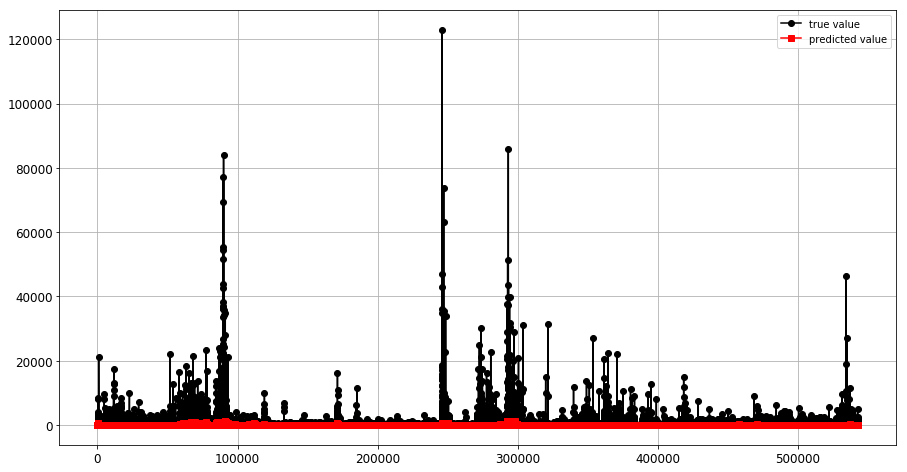

In [29]:
fig, ax = plt.subplots()
ax.plot(index, tr_points, 'ko-', label='true value')
ax.plot(index, pr_points, 'rs-', label='predicted value')
# ax.set_xlabel('每个销售中心每个客户的每件产品', fontsize=16)
# ax.set_ylabel('产品的销量', fontsize=16)
# ax.set_title('实际值和预测值对比', fontsize=20)
ax.legend(loc='upper right')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()